## Surface Fluxes Taylor Series Expansion
This looks at the taylor series expansion of variables that contribute to each individual flux.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils.constants import R
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, get_scale_factor_theory
from isca_tools.thesis.surface_flux_taylor import get_latent_heat, get_sensitivity_lh, reconstruct_lh, name_nl, name_square, reconstruct_sh
import inspect
import copy
import jobs.thesis_season.thesis_figs.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [18]:
sigma_atm = 0.995
vals_ref = {'p_surf': 1000 * 100, 'evap_prefactor': 1, 'drag_coef': 0.0009, 'w_atm': 10, 'temp_diseqb': 5, 'rh_atm': 0.7, 'temp_surf': 290}
n_anom = 21
anom_max = {key: vals_ref[key] * 0.5 for key in vals_ref}
anom_max['temp_surf'] = 20
vals = {key: vals_ref[key] + np.linspace(-anom_max[key], anom_max[key], n_anom) for key in vals_ref}

vals_all = {f"{key}_ref": vals_ref[key] for key in vals_ref}            # include ref and arrays
for key in vals:
    vals_all[key] = vals[key]

## Latent Heat

Note that the `evap_prefactor`, `drag_coef` and `w_atm` plots all overlap because they have the same differential.

It works pretty well, giving confidence the equations are correct. For the mechanism combination on the right, I think the $T_s^2$ term is important, hence the deviation at extreme values.

In [19]:
lh_ref, _, _, info_cont_lh = reconstruct_lh(**vals_all, sigma_atm=sigma_atm, numerical=False)
info_cont_lh_num = reconstruct_lh(**vals_all, sigma_atm=sigma_atm, numerical=True)[-1]

# For nonlinear contribution make temp_surf_anom always positive so combination of mechanisms goes from neg to pos
# I.e., anom_temp_surf * anom_var goes from negative to positive
vals_all_lh_nl = copy.deepcopy(vals_all)
vals_all_lh_nl['temp_surf'] = vals_ref['temp_surf'] + np.abs(vals['temp_surf']-vals_ref['temp_surf'])
var = reconstruct_lh(**vals_all_lh_nl, sigma_atm=sigma_atm, numerical=False)[-1]
var2 = reconstruct_lh(**vals_all_lh_nl, sigma_atm=sigma_atm, numerical=True)[-1]
for key in info_cont_lh:
    if ('nl' in key) and ('square' not in key):
        info_cont_lh[key] = var[key]
        info_cont_lh_num[key] = var2[key]

In [20]:
colors_use = {'p_surf': 'C5', 'evap_prefactor': 'C6', 'drag_coef': 'C4', 'w_atm': 'C3', 'temp_diseqb': 'C2',
              'rh_atm': 'C0', 'temp_surf': 'C1'}

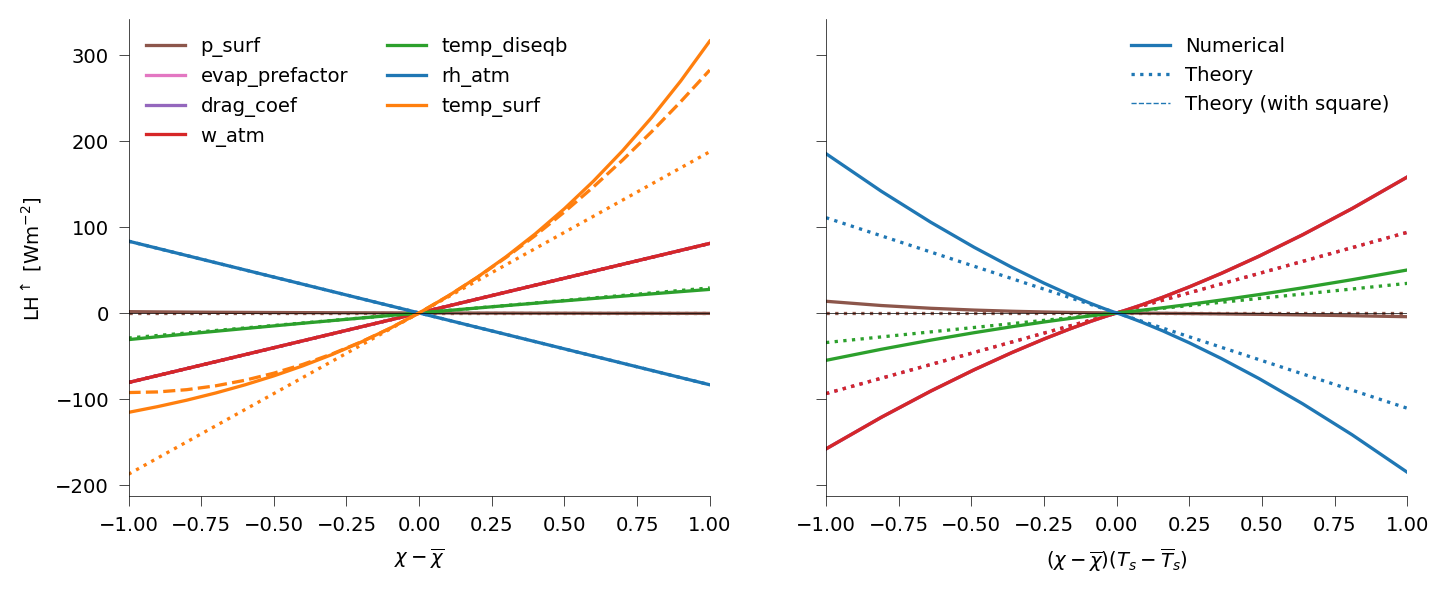

In [21]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col']*1.5)
for i, key in enumerate(vals_ref):
    ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], info_cont_lh_num[key], color=colors_use[key], label=key)
    ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], info_cont_lh[key], color=colors_use[key], linestyle=':')
    if name_square(key) in info_cont_lh:
        ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], info_cont_lh[key]+info_cont_lh[name_square(key)],
                   color=colors_use[key], linestyle='--')
    else:
        # NL combination with temp_surf
        var = (vals_all_lh_nl['temp_surf']-vals_ref['temp_surf']) * (vals_all_lh_nl[key]-vals_ref[key])
        ax[1].plot(var/np.max(var), info_cont_lh_num[name_nl('temp_surf', key)], color=colors_use[key],
                   label='Numerical' if key=='rh_atm' else None)
        ax[1].plot(var/np.max(var), info_cont_lh[name_nl('temp_surf', key)], color=colors_use[key],
                   linestyle=':', label='Theory' if key=='rh_atm' else None)
ax[0].set_ylabel(f"{utils.style_map['lh'][2]} ""[Wm$^{-2}$]")
ax[0].set_xlabel('$\chi-\overline{\chi}$')
ax[1].set_xlabel('$(\chi-\overline{\chi})(T_s-\overline{T}_s)$')
update_linewidth(fig)
ax[0].legend(ncol=2)
ax[1].plot(-10, 0, color=colors_use['rh_atm'], linestyle='--', label='Theory (with square)')
ax[1].legend()
ax[0].set_xlim(-1, 1)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
update_fontsize(fig, 6)
plt.show()

## Sensible Heat

Note that the `p_surf`, `drag_coef` and `w_atm` plots all overlap because they have the same differential.

It works very well, giving confidence the equations are correct. It is clear that no squared terms are important here, and maybe only the nonlinear contribution between `w_atm` and `temp_diseqb`.

In [22]:
vals_sh = {key2: vals_all[key2] for key2 in [key for key in vals_all if key in inspect.signature(reconstruct_sh).parameters]}
sh_ref, _, _, info_cont_sh = reconstruct_sh(**vals_sh, sigma_atm=sigma_atm, numerical=False)
info_cont_sh_num = reconstruct_sh(**vals_sh, sigma_atm=sigma_atm, numerical=True)[-1]

# For nonlinear contribution make temp_surf_anom always positive so combination of mechanisms goes from neg to pos
# I.e., anom_temp_surf * anom_var goes from negative to positive
vals_sh_nl = copy.deepcopy(vals_sh)
vals_sh_nl['temp_diseqb'] = vals_ref['temp_diseqb'] + np.abs(vals['temp_diseqb']-vals_ref['temp_diseqb'])
var = reconstruct_sh(**vals_sh_nl, sigma_atm=sigma_atm, numerical=False)[-1]
var2 = reconstruct_sh(**vals_sh_nl, sigma_atm=sigma_atm, numerical=True)[-1]
for key in info_cont_sh:
    if ('nl' in key) and ('square' not in key):
        info_cont_sh[key] = var[key]
        info_cont_sh_num[key] = var2[key]

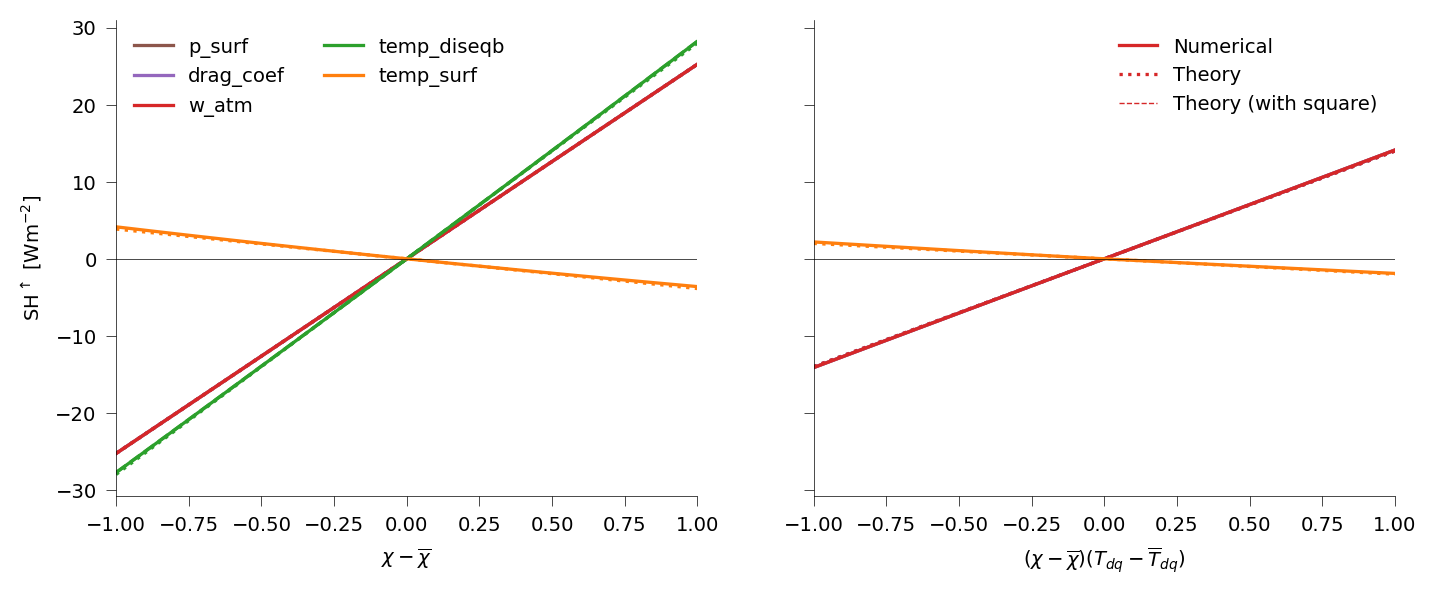

In [25]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col']*1.5)
for i, key in enumerate(vals_sh):
    if 'ref' in key:
        continue
    ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], info_cont_sh_num[key], color=colors_use[key], label=key)
    ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], info_cont_sh[key], color=colors_use[key], linestyle=':')
    if name_square(key) in info_cont_sh:
        ax[0].plot((vals[key]-vals_ref[key])/anom_max[key], info_cont_sh[key]+info_cont_sh[name_square(key)],
                   color=colors_use[key], linestyle='--')
    else:
        # NL combination with temp_surf
        var = (vals_sh_nl['temp_diseqb']-vals_ref['temp_diseqb']) * (vals_sh_nl[key]-vals_ref[key])
        if name_nl('temp_diseqb', key) in info_cont_sh:
            key2 = name_nl('temp_diseqb', key)
        else:
            key2 = name_nl(key, 'temp_diseqb')
        ax[1].plot(var/np.max(var), info_cont_sh_num[key2], color=colors_use[key],
                   label='Numerical' if key=='w_atm' else None)
        ax[1].plot(var/np.max(var), info_cont_sh[key2], color=colors_use[key],
                   linestyle=':', label='Theory' if key=='w_atm' else None)
ax[0].set_ylabel(f"{utils.style_map['sh'][2]} ""[Wm$^{-2}$]")
ax[0].set_xlabel('$\chi-\overline{\chi}$')
ax[1].set_xlabel('$(\chi-\overline{\chi})(T_{dq}-\overline{T}_{dq})$')
update_linewidth(fig)
ax[0].legend(ncol=2)
ax[1].plot(-10, 0, color=colors_use['w_atm'], linestyle='--', label='Theory (with square)')
ax[1].legend()
ax[0].set_xlim(-1, 1)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
update_fontsize(fig, 6)
plt.show()